<a href="https://colab.research.google.com/github/YooNayoung/ESAA/blob/main/%EC%88%98%EC%83%81%EC%9E%91_%EB%A6%AC%EB%B7%B0_3%ED%9A%8C%EC%B0%A8(%EB%86%8D%EC%97%85_%ED%99%98%EA%B2%BD_%EB%B3%80%ED%99%94%EC%97%90_%EB%94%B0%EB%A5%B8_%EC%9E%91%EB%AC%BC_%EB%B3%91%ED%95%B4_%EC%A7%84%EB%8B%A8_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 데이터 
  
  1) 이미지 : augmentation (flip, contrast, cutmix..)
  
  2) 시퀀스 : 중복된 시간을 가지는 데이터의 경우 "sequence[::2] , sequence[1::2]"중 random으로 골라서 max_length 가 300이하가 되도록 했습니다.

2. 모델
  - convnext, efficientnet, vit등 다양한 모델을 사용하였으나 resnext50_32x4d의 성능이 가장 좋아 해당 모델을 5fold 앙상블 하여 사용했습니다.

3. 훈련
  
  1) optimizer로는 AdamW, 스케줄러로는 cosine_schedule_with_warmup을 사용하였습니다.
  
  1) 5 fold로 5개의 모델을 훈련시켰고, 모두 25epoch 중 가장 좋은 validation score 를 가진 모델의weight를 각각 저장했습니다.
  
  2) cutmix는 25epoch중 15epoch까지만 적용하였습니다.


4. 추론
  - 5개의 모델의 output을 단순 평균하여 사용했습니다.



1. train : 학습용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.jpg : 이미지 파일

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.json :

	│		├ description 

	│		│	├ image : 이미지 파일 이름

	│		│	├ date : 촬영 날짜

	│		│	├ time : 촬영 시간

	│		│	├ region : 촬영 지역

	│		│	├ height : 이미지 높이

	│		│	├ width : 이미지 너비

	│		│	└  task : 데이터 종류 (질병/해충/병해/정상 구분)

	│		└ annotations

	│				├ disease : 작물 상태 코드

	│				├ crop : 작물 코드

	│				├ area : 작물 촬영 부위

	│				├ grow : 작물의 생육 단계 

	│				├ risk : 질병 피해 정도

	│				├ bbox : 주목 객체 바운딩 박스 (x, y, w, h 형태)

	│				└ part : 병해 부위 바운딩 박스 (x, y, w, h 형태)

	│

	├ 10002

	├ 10003

	└ ...

	[추가] train.csv : train set에 대한 정답 파일

 - image : 이미지 파일 이름
 - label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"




2. test : 평가용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.jpg : 이미지 파일

	│

	├ 10002

	├ 10003

	└ ...



3. sample_submission.csv : 제출용 양식

 - image : 이미지 파일 이름
 - label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"

# **모델 생성 및 학습**



In [2]:
# import google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pakage

!pip uninstall opencv-python-headless==4.5.5.62 --yes
!pip install opencv-python-headless==4.1.2.30

import pickle
import gc
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from glob import glob
import random
import os
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# timm : 0.5.4
!pip install timm
# albumtations : 1.1.0
!pip install -U albumentations
# transformers : 4.16.2
!pip install transformers

import timm
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
# unzip train data

!unzip "/content/drive/MyDrive/ESAA(OB)/농업 환경 변화에 따른 작물 병해 진단 AI 경진대회/train.zip"
!unzip "/content/drive/MyDrive/ESAA(OB)/농업 환경 변화에 따른 작물 병해 진단 AI 경진대회/test.zip"

In [9]:
train_label = pd.read_csv("/content/drive/MyDrive/ESAA(OB)/농업 환경 변화에 따른 작물 병해 진단 AI 경진대회/train.csv")
train_label.head()

,image,label
0,10027,3_b7_1
1,10037,3_00_0
2,10043,3_00_0
3,10045,3_00_0
4,10063,3_00_0


In [6]:
csv_sample = pd.read_csv("/content/train/10027/10027.csv")
csv_sample.head()

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-11-26 09:30:00,9.0,9.6,8.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-11-26 09:30:00,8.7,9.3,8.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-11-26 09:20:00,7.9,8.4,7.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-11-26 09:20:00,7.4,7.9,6.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-11-26 09:10:00,6.9,7.2,6.6,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


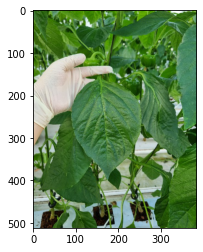

In [12]:
from PIL import Image
jpg_sample = Image.open("/content/train/10027/10027.jpg")
plt.imshow(jpg_sample)

In [14]:
import json
with open("/content/train/10027/10027.json") as f:
     json_sample = json.load(f)

json_sample

{'description': {'date': '20211126',
  'image': '10027.jpg',
  'task': 2,
  'width': 384,
  'time': '0935',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': 'b7',
  'grow': 13,
  'bbox': [{'x': 89.14301990327381,
    'h': 237.8629402281746,
    'y': 162.00396825396825,
    'w': 165.0040302579365}],
  'part': [{'x': 125.57248263888889,
    'h': 78.85906498015873,
    'y': 177.43291170634922,
    'id': 0,
    'w': 32.14364769345238},
   {'x': 162.8591114831349,
    'h': 57.858568948412696,
    'y': 187.290287078373,
    'id': 1,
    'w': 35.57229662698413}],
  'risk': 1,
  'crop': 3}}

In [5]:
# get sequence feature information
# 결측치가 아닌 변수들만

csv_feature_dict = {'내부 습도 1 최고': [25.9, 100.0],
                    '내부 습도 1 최저': [0.0, 100.0],
                    '내부 습도 1 평균': [23.7, 100.0],
                    '내부 온도 1 최고': [3.4, 47.6],
                    '내부 온도 1 최저': [3.3, 47.0],
                    '내부 온도 1 평균': [3.4, 47.3],
                    '내부 이슬점 최고': [0.2, 34.7],
                    '내부 이슬점 최저': [0.0, 34.4],
                    '내부 이슬점 평균': [0.1, 34.5]}

In [6]:
# label encoder, decoder 

train_json = sorted(glob('/content/train/*/*.json'))

labels = []
for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
        labels.append(label)

label_encoder = sorted(np.unique(labels))
label_encoder = {key:value for key,value in zip(label_encoder, range(len(label_encoder)))}
label_decoder = {val:key for key, val in label_encoder.items()}

In [16]:
label_encoder

{'1_00_0': 0,
 '2_00_0': 1,
 '2_a5_2': 2,
 '3_00_0': 3,
 '3_a9_1': 4,
 '3_a9_2': 5,
 '3_a9_3': 6,
 '3_b3_1': 7,
 '3_b6_1': 8,
 '3_b7_1': 9,
 '3_b8_1': 10,
 '4_00_0': 11,
 '5_00_0': 12,
 '5_a7_2': 13,
 '5_b6_1': 14,
 '5_b7_1': 15,
 '5_b8_1': 16,
 '6_00_0': 17,
 '6_a11_1': 18,
 '6_a11_2': 19,
 '6_a12_1': 20,
 '6_a12_2': 21,
 '6_b4_1': 22,
 '6_b4_3': 23,
 '6_b5_1': 24}

In [17]:
label_decoder

{0: '1_00_0',
 1: '2_00_0',
 2: '2_a5_2',
 3: '3_00_0',
 4: '3_a9_1',
 5: '3_a9_2',
 6: '3_a9_3',
 7: '3_b3_1',
 8: '3_b6_1',
 9: '3_b7_1',
 10: '3_b8_1',
 11: '4_00_0',
 12: '5_00_0',
 13: '5_a7_2',
 14: '5_b6_1',
 15: '5_b7_1',
 16: '5_b8_1',
 17: '6_00_0',
 18: '6_a11_1',
 19: '6_a11_2',
 20: '6_a12_1',
 21: '6_a12_2',
 22: '6_b4_1',
 23: '6_b4_3',
 24: '6_b5_1'}

In [7]:
# hyper parameters

opt = dict()

opt['batch_size'] = 16
opt['class_n'] = len(label_encoder)
opt['lr'] = 2e-4
opt['embedding_dim'] = 512
opt['feature_n'] = len(csv_feature_dict)
opt['max_len'] = 300
opt['dropout_rate'] = 0.3
opt['epoch_n'] = 25
opt['vision_pretrain'] = True
opt['worker_n'] = 8
opt['folder'] = 'model_weights'
opt['bidirectional'] = True
opt['minmax_dict'] = csv_feature_dict
opt['label_dict'] = label_encoder
opt['enc_name'] = 'resnext50_32x4d'
opt['enc_dim'] = 2048
opt['dec_dim'] = 1024
opt['img_size1'] = 384
opt['img_size2'] = 384
opt['precision'] = 'amp'
opt['seed'] = 42
opt['mix'] = 'cutmix'
opt['mix_prob'] = 0.3
opt['mean'] = [0.485, 0.456, 0.406]
opt['std'] = [0.229, 0.224, 0.225]


device = torch.device("cuda:0")

In [8]:
# fix seed 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(opt['seed'])

### cutmix란?
:이미지 기반 태스크의 성능을 끌어올리기 위한 data augmentation 기법 중 하나. 기존 Mixup, Cutout 등과 같은 방법들은 이미지에서 일부분을 잘라내서 0으로 채우거나 다른 이미지와 겹침으로써 CNN으로 하여금 이미지의 덜 중요한 부분까지 포커싱하게 만드는 regional dropout 전략. 하지만 아래 그림과 같이 Cutout은 이미지의 일부분을 아예 삭제하여 정보 손실을 유발하고 Mixup은 다른 이미지와 interpolate 함으로써 이미지 정보가 왜곡되는 현상 발생. CutMix는 Mixup/Cutout에서 더 나아가 cut-and-paste 방법을 취해 이미지 일부분을 다른 이미지의 패치로 채우는 기법으로 image classification, weakly-supervised localization 태스크 등에서 일관된 높은 성능을 거둠.
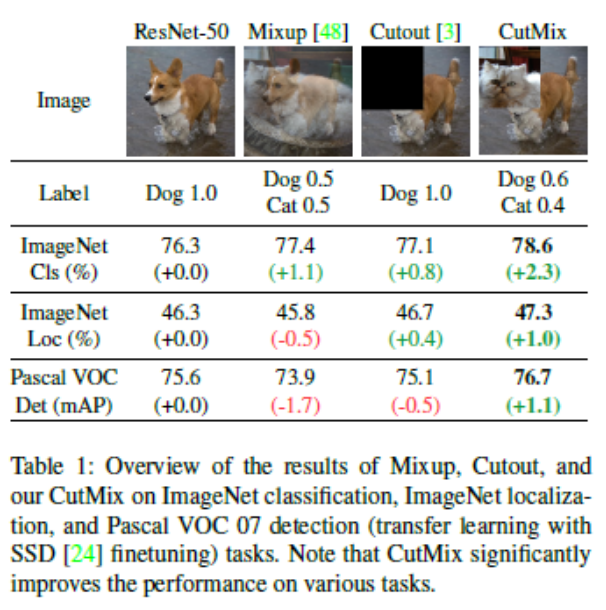

함수작성은 다음과 같은 알고리즘을 이용한 것으로 보임
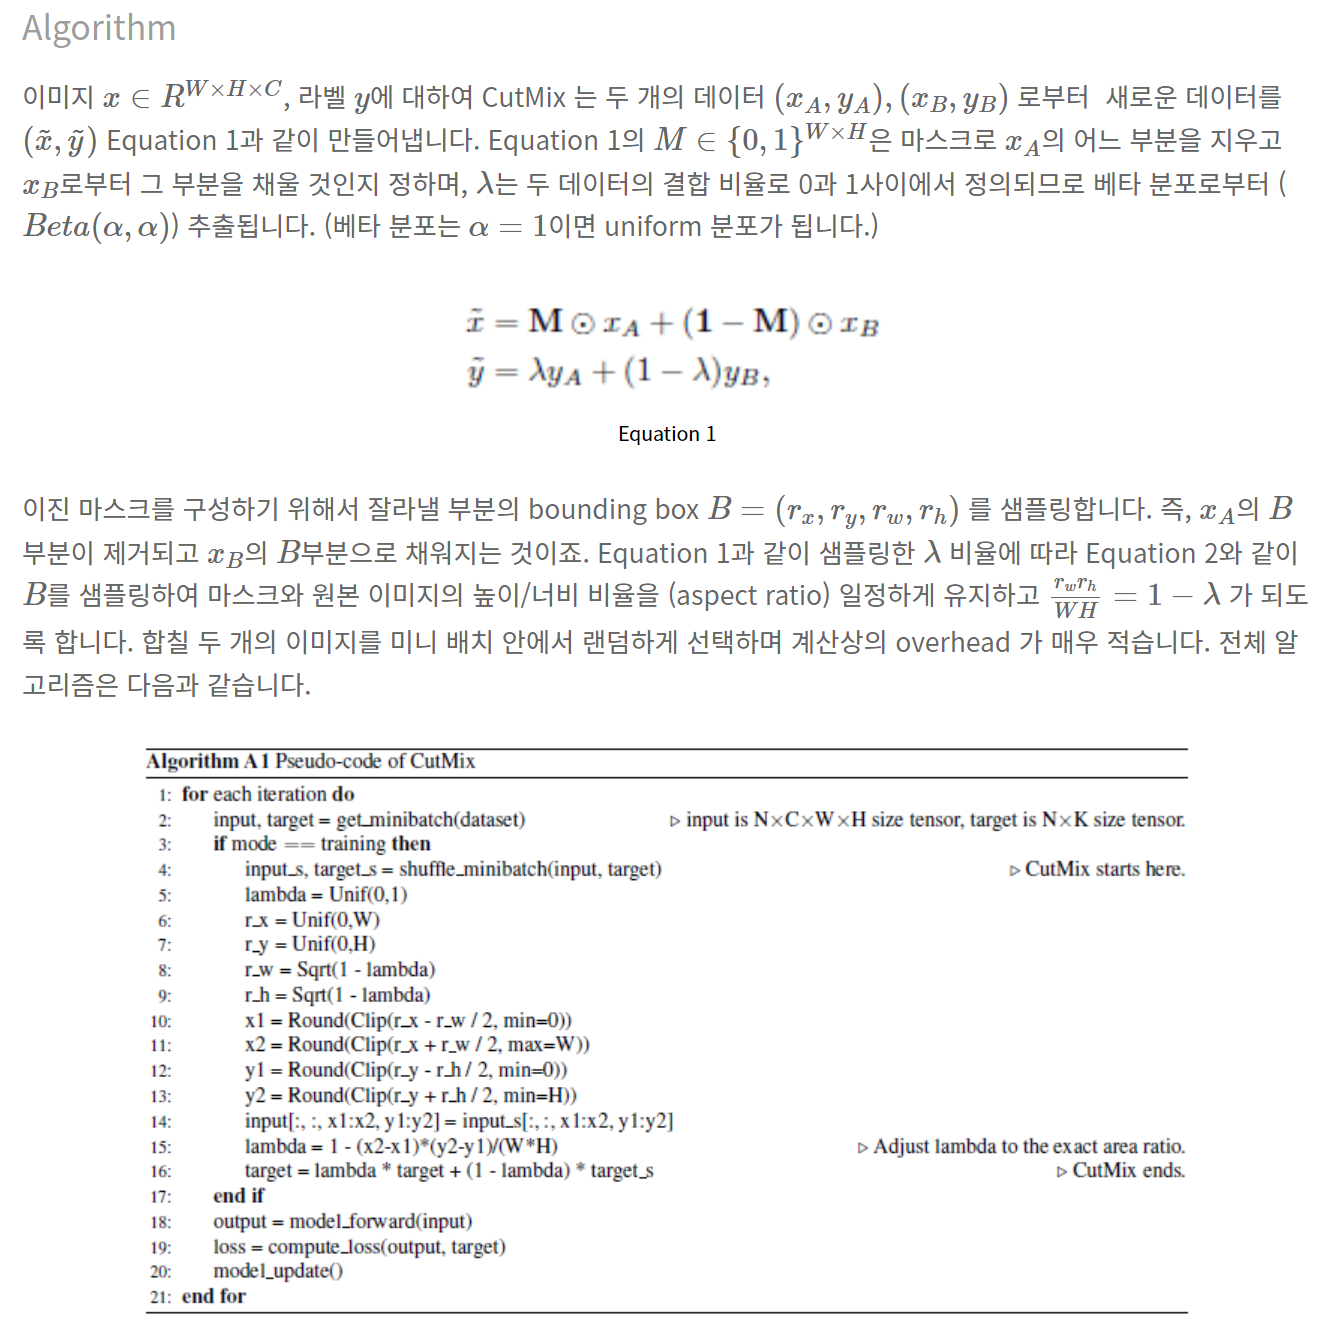

In [9]:
# cutmix function

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

In [10]:
# get data

train = sorted(glob('/content/train/*'))
test = sorted(glob('/content/test/*'))
labelsss = pd.read_csv('/content/drive/MyDrive/ESAA(OB)/농업 환경 변화에 따른 작물 병해 진단 AI 경진대회/train.csv')['label']

In [11]:
# k-fold cross validation

skf = StratifiedKFold(n_splits = 5)
train = shuffle(train, random_state=opt['seed'])

folds = []
for idx, (train_idx, val_idx) in enumerate(skf.split(train, labelsss)):
    folds.append((train_idx, val_idx))

## augmentation 정의하는 코드


```
from albumentations import *

def test_aug():
    ret = Compose([
        ElasticTransform(),
        GridDistortion(),
        HorizontalFlip(),
        OpticalDistortion(),
        ShiftScaleRotate(),
        VerticalFlip()
    ])
    return ret
```

- 이미지를 회전하는 정도의 처리 3개 : HorizontalFlip(), VerticalFlip(), ShiftScaleRotate()
- 이미지를 변형하는 정도의 처리 3개 : ElasticTransform(), GridDistortion(), OpticalDistortion()
- 각각의 처리에는 p(확률값)을 주어서 처리할 수 있는데 디폴트 값은 0.5
- 출처: https://biology-statistics-programming.tistory.com/169 

In [12]:
# dataset

def trainTransform():
  return Compose([
                  Transpose(p=0.5),
                  HorizontalFlip(p=0.5),
                  VerticalFlip(p=0.5),
                  ShiftScaleRotate(p=0.5),
                  RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                  Resize(opt['img_size1'], opt['img_size2']),
                  Normalize(mean=opt['mean'], std=opt['std'], max_pixel_value=255.0, p=1.0),
                  ToTensorV2(p=1.0),
                  ], p=1.)
  
def valTransform():
  return Compose([
                  Resize(opt['img_size1'], opt['img_size2']),
                  Normalize(mean=opt['mean'], std=opt['std'], max_pixel_value=255.0, p=1.0),
                  ToTensorV2(p=1.0),
              ], p=1.)

class CustomDataset(Dataset):
    def __init__(self, opt, files, mode, transforms):
        self.files = files
        self.mode = mode
        self.transforms = transforms
        self.csv_check = [0]*len(self.files)
        self.seq = [None]*len(self.files)
        self.minmax_dict = opt['minmax_dict']
        self.max_len = opt['max_len']
        self.label_encoder = opt['label_dict']

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        if self.csv_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)
            try:
                estiTime1, estiTime2 = df.iloc[0]['측정시각'], df.iloc[1]['측정시각']
            except:
                estiTime1, estiTime2 = 0, 1

            df = df[self.minmax_dict.keys()]
            df = df.replace('-', 0)
            
            if self.mode == 'train':
                decision = np.random.rand()
                if estiTime1==estiTime2 and len(df)>400:
                    if decision > 0.5:
                        df = df[0::2].reset_index(drop=True)
                    else:
                        df = df[1::2].reset_index(drop=True)
            else: 
                if estiTime1==estiTime2 and len(df)>400:
                    df = df[0::2].reset_index(drop=True)
                
            
            # minmax-scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.minmax_dict[col][0]
                df[col] = df[col] / (self.minmax_dict[col][1]-self.minmax_dict[col][0])

            # zero-padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]

            # transpose-to-sequential-data
            seq = torch.tensor(pad, dtype=torch.float32)
            self.seq[i] = seq
            self.csv_check[i] = 1
        else:
            seq = self.seq[i]
        
        # image-transform
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)              
        img = self.transforms(image=img)['image'] 

        
        if self.mode == 'train' or self.mode == 'val':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = torch.tensor(self.label_encoder[f'{crop}_{disease}_{risk}'], dtype=torch.long)
            
            return img, seq, label
        else:
            return img, seq

In [13]:
# model

class Encoder(nn.Module):
    def __init__(self, opt):
        super(Encoder, self).__init__()
        self.model = timm.create_model(model_name=opt['enc_name'], 
                                       pretrained=opt['vision_pretrain'], 
                                       num_classes=0)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output


class Decoder(nn.Module):
    def __init__(self, opt):
        super(Decoder, self).__init__()
        self.decoder = nn.GRU(opt['feature_n'], opt['embedding_dim'], bidirectional = opt['bidirectional'])
        self.dense = nn.Linear(2*opt['max_len']*opt['embedding_dim'], opt['dec_dim'])
        
        self.f1 = nn.Linear(opt['enc_dim']+opt['dec_dim'], opt['enc_dim']+opt['dec_dim'])
        self.out = nn.Linear(opt['enc_dim']+opt['dec_dim'], opt['class_n'])
        self.dropout = nn.Dropout(opt['dropout_rate'])
        self.relu = nn.ReLU()

    def init_weight(self):
        torch.nn.init.xavier_uniform_(self.f1.weight)  
        torch.nn.init.xavier_uniform_(self.dense.weight)  
        torch.nn.init.xavier_uniform_(self.out.weight)  


    def forward(self, enc_out, dec_inp):
        dec_out, _ = self.decoder(dec_inp)
        dec_out = self.dense(dec_out.view(dec_out.size(0), -1))

        concat = torch.cat([enc_out, dec_out], dim=1) 
        concat = self.f1(self.relu(concat))
        concat = self.dropout(self.relu(concat))
        output = self.out(concat)
        return output


class CustomModel(nn.Module):
    def __init__(self, opt):
        super(CustomModel, self).__init__()
        self.encoder = Encoder(opt)
        self.decoder = Decoder(opt)
        self.to(device)
        
    def forward(self, img, seq):
        enc_out = self.encoder(img)
        output = self.decoder(enc_out, seq)
        
        return output

## AdamW (Optimizer)
L2 regularization 텀이 추가된 loss function을 Adam을 이용해서 최적화 할 경우, 의도와 달리 일반화 효과과 떨어질 수 있음. 따라서 L2 regularization과 별도로 weight decay를 위한 텀을 수식에 추가한 것이 AdamW임.

In [14]:
# train function

class CustomTrainer:
    def __init__(self, model, folder, fold):
        self.model=model
        
        self.save_dir = f'/content/{folder}'
        if not os.path.exists(self.save_dir):
          os.makedirs(self.save_dir)
          
        self.optimizer = AdamW(model.parameters(), lr=opt['lr'])
        self.scaler = torch.cuda.amp.GradScaler() 

        total_steps = int(len(train_dataset)*opt['epoch_n']/(opt['batch_size']))
        warmup_steps = 1149
        print('total_steps: ', total_steps)
        print('warmup_steps: ', warmup_steps)
        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
        self.loss_fn = nn.CrossEntropyLoss()
        self.val_loss_fn = nn.CrossEntropyLoss()

        self.best_score = 0.0


    def run(self, train_loader, val_loader):
        for epoch in range(opt['epoch_n']):
            gc.collect()
            learning_rate = self.optimizer.param_groups[0]['lr']
            print('learning_rate: ', learning_rate)
            print(f'----- train, epoch{epoch+1} -----')
            train_loss, train_score = self.train_function(train_loader, epoch)
            print(' ')
            print(f'train_loss: {train_loss:.6f}, train_score: {train_score:.6f}')

            print('----------------------------------')

            print(f'----- val, epoch{epoch+1} -----')
            with torch.no_grad():
                val_loss, val_score = self.val_function(val_loader)
            print(' ')
            print(f'val_loss: {val_loss:.6f}, val_score: {val_score:.6f}')


            if epoch+1 >= 16 and val_score >= self.best_score:
                torch.save(self.model.state_dict(), self.save_dir+f"/best-acc-epoch{epoch+1}.bin")
                self.best_score=val_score
                print(f'model is saved when epoch is : {epoch+1}')


    def train_function(self, train_loader, epoch):
        self.model.train()

        total_loss = 0.0
        total_score = 0.0
        for bi, data in enumerate(tqdm(train_loader)):
            data = [x.to(device) for x in data]
            img, seq, label = data

            self.optimizer.zero_grad()
            
            # use mix or not
            if opt['mix']!=None and epoch < opt['epoch_n']-10: 
                mix_decision = np.random.rand()
                if opt['mix'] == 'cutmix' and mix_decision < opt['mix_prob']:
                    img, mix_labels = cutmix(img, label, 1.0)
                else: 
                  pass
            else: mix_decision = 1

            if opt['epoch_n']-10 <= epoch:
                assert mix_decision == 1
            
            # use amp or not
            if opt['precision'] == 'float':
                out = self.model(img, seq)

                if mix_decision < opt['mix_prob']:
                    loss = self.loss_fn(out, mix_labels[0])*mix_labels[2] + self.loss_fn(out, mix_labels[1])*(1-mix_labels[2])
                else:
                    loss = self.loss_fn(out, label)

                loss.backward()
                self.optimizer.step()
            else: 
                with torch.cuda.amp.autocast():
                    out = self.model(img, seq)
                    if mix_decision < opt['mix_prob']:
                        loss = self.loss_fn(out, mix_labels[0])*mix_labels[2] + self.loss_fn(out, mix_labels[1])*(1-mix_labels[2])
                    else:
                        loss = self.loss_fn(out, label)

                self.scaler.scale(loss).backward()  
                self.scaler.step(self.optimizer) 
                self.scaler.update()              
            
            self.scheduler.step()
            total_loss+=loss.detach().cpu()

            total_score+=f1_score(label.cpu(), out.argmax(1).cpu(), average='macro')
        return total_loss/len(train_loader), total_score/len(train_loader)

    def val_function(self, val_loader):
        self.model.eval()

        total_loss = 0.0
        preds, targets = [], []
        for bi, data in enumerate(tqdm(val_loader)):
            data = [x.to(device) for x in data]
            img, seq, label = data

            out = self.model(img, seq)
            loss = self.val_loss_fn(out, label)

            total_loss+=loss.detach().cpu()

            pred = out.argmax(1).detach().cpu().tolist()
            target = label.reshape(-1).detach().cpu().tolist()

            preds.extend(pred)
            targets.extend(target)
        
        score = f1_score(targets, preds, average='macro')
        return total_loss/len(val_loader), score

    def log(self, message):
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [ ]:
# run

print(opt)
for i in range(len(folds)):
    train_idx, val_idx = folds[i]
    
    print(f'{i+1}th fold training is start')
    
    # data
    train_dataset = CustomDataset(opt, np.array(train)[train_idx], mode='train', transforms=trainTransform())
    val_dataset = CustomDataset(opt, np.array(train)[val_idx], mode='val', transforms=valTransform())
    print('num of train: ', len(train_dataset))
    print('num of val: ', len(val_dataset))

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, num_workers=opt['worker_n'], shuffle=True, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2*12, num_workers=opt['worker_n'], shuffle=False)

    # model
    custom_model = CustomModel(opt)

    # trainer
    custom_trainer = CustomTrainer(model=custom_model, folder=opt['folder']+f'/fold{i+1}', fold=i+1)
    custom_trainer.run(train_dataloader, val_dataloader)

# **추론**

In [25]:
# get data

test = sorted(glob('/content/test/*'))

In [26]:
# model

class Encoder(nn.Module):
    def __init__(self, opt):
        super(Encoder, self).__init__()
        self.model = timm.create_model(model_name=opt['enc_name'], 
                                       pretrained=opt['vision_pretrain'], 
                                       num_classes=0)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output


class Decoder(nn.Module):
    def __init__(self, opt):
        super(Decoder, self).__init__()
        self.decoder = nn.GRU(opt['feature_n'], opt['embedding_dim'], bidirectional = opt['bidirectional'])
        self.dense = nn.Linear(2*opt['max_len']*opt['embedding_dim'], opt['dec_dim'])
        
        self.f1 = nn.Linear(opt['enc_dim']+opt['dec_dim'], opt['enc_dim']+opt['dec_dim'])
        self.out = nn.Linear(opt['enc_dim']+opt['dec_dim'], opt['class_n'])
        self.dropout = nn.Dropout(opt['dropout_rate'])
        self.relu = nn.ReLU()

    def init_weight(self):
        torch.nn.init.xavier_uniform_(self.f1.weight)  
        torch.nn.init.xavier_uniform_(self.dense.weight)  
        torch.nn.init.xavier_uniform_(self.out.weight)  


    def forward(self, enc_out, dec_inp):
        dec_out, _ = self.decoder(dec_inp)
        dec_out = self.dense(dec_out.view(dec_out.size(0), -1))

        concat = torch.cat([enc_out, dec_out], dim=1) 
        concat = self.f1(self.relu(concat))
        concat = self.dropout(self.relu(concat))
        output = self.out(concat)
        return output


class CustomModel(nn.Module):
    def __init__(self, opt):
        super(CustomModel, self).__init__()
        self.encoder = Encoder(opt)
        self.decoder = Decoder(opt)
        self.to(device)
        
    def forward(self, img, seq):
        enc_out = self.encoder(img)
        output = self.decoder(enc_out, seq)
        
        return output

In [ ]:
# get model weights

custom_model = CustomModel(opt)

model1_path = glob(opt['folder'] + '/fold1/*.bin')[-1]
model2_path = glob(opt['folder'] + '/fold2/*.bin')[-1]
model3_path = glob(opt['folder'] + '/fold3/*.bin')[-1]
model4_path = glob(opt['folder'] + '/fold4/*.bin')[-1]
model5_path = glob(opt['folder'] + '/fold5/*.bin')[-1]

# fold1 model
model1 = CustomModel(opt)
model1.load_state_dict(torch.load(model1_path, map_location='cpu'))
model1.to(device)
model1.eval()

# fold2 model
model2 = CustomModel(opt)
model2.load_state_dict(torch.load(model2_path, map_location='cpu'))
model2.to(device)
model2.eval()

# fold3 model
model3 = CustomModel(opt)
model3.load_state_dict(torch.load(model3_path, map_location='cpu'))
model3.to(device)
model3.eval()

# fold4 model
model4 = CustomModel(opt)
model4.load_state_dict(torch.load(model4_path, map_location='cpu'))
model4.to(device)
model4.eval()

# fold5 model
model5 = CustomModel(opt)
model5.load_state_dict(torch.load(model5_path, map_location='cpu'))
model5.to(device)
model5.eval()

'model weight is loaded'

In [ ]:
# inference dataset

def valTransform():
  return Compose([
                  Resize(opt['img_size1'], opt['img_size2']),
                  Normalize(mean=opt['mean'], std=opt['std'], max_pixel_value=255.0, p=1.0),
                  ToTensorV2(p=1.0),
              ], p=1.)
  
class InferenceDataset(Dataset):
    def __init__(self, opt, files, mode):
        self.files = files
        self.mode = mode
        self.csv_check = [0]*len(self.files)
        self.seq = [None]*len(self.files)
        self.minmax_dict = opt['minmax_dict']
        self.max_len = opt['max_len']
        self.label_encoder = opt['label_dict']

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        if self.csv_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)
            try:
                estiTime1, estiTime2 = df.iloc[0]['측정시각'], df.iloc[1]['측정시각']
            except:
                estiTime1, estiTime2 = 0, 1

            df = df[self.minmax_dict.keys()]
            df = df.replace('-', 0)
            
            if estiTime1==estiTime2 and len(df)>400:
                df = df[0::2].reset_index(drop=True)
                
            
            # minmax-scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.minmax_dict[col][0]
                df[col] = df[col] / (self.minmax_dict[col][1]-self.minmax_dict[col][0])

            # zero-padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]

            # transpose-to-sequential-data
            seq = torch.tensor(pad, dtype=torch.float32)
            self.seq[i] = seq
            self.csv_check[i] = 1
        else:
            seq = self.seq[i]
        
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)
        img = valTransform()(image=img)['image'] 

        if self.mode == 'val':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = torch.tensor(self.label_encoder[f'{crop}_{disease}_{risk}'], dtype=torch.long)
            
            return img, seq, label
        else:
            return img, seq

In [ ]:
# predict function

def predict(models, loader, mode):
    model1, model2, model3, model4, model5 = models

    preds = []
    for bi, data in enumerate(tqdm(loader)):
        data = [x.to(device) for x in data]
        if mode=='val':
            img, seq, label = data
        else:
            img, seq = data
        output1 = nn.Softmax(dim=-1)(model1(img, seq))
        output2 = nn.Softmax(dim=-1)(model2(img, seq))
        output3 = nn.Softmax(dim=-1)(model3(img, seq))
        output4 = nn.Softmax(dim=-1)(model4(img, seq))
        output5 = nn.Softmax(dim=-1)(model5(img, seq))

        output = output1 + output2 + output3 + output4 + output5
        pred = torch.argmax(output, dim=1).cpu().tolist()
        preds.extend(pred)
    return preds

In [ ]:
# get test preds

models = [model1, model2, model3, model4, model5]

test_dataset = InferenceDataset(opt, test, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2*12, num_workers=opt['worker_n'], shuffle=False)

with torch.no_grad():
    preds = predict(models, test_dataloader, mode='test')

In [ ]:
preds = np.array([label_decoder[int(x)] for x in preds])

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ESAA(OB)/농업 환경 변화에 따른 작물 병해 진단 AI 경진대회/sample_submission.csv')
submission['label'] = preds